In [1]:
#### General modules
import os

# Model modules
import datetime as dt
import matplotlib.pyplot as plt # Graphics
import numpy as np # Scientific computation
import pandas as pd # Database management

# Torch (estimation) essentials
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

torch.manual_seed(42)
np.random.seed(42)

In [2]:
os.chdir('/home/chechgm/Courses/02456-deep-learning-with-PyTorch/Final_project')
print(os.getcwd())

/home/chechgm/Courses/02456-deep-learning-with-PyTorch/Final_project


In [3]:
crimen = pd.read_csv('./data/CrimenBogota.txt', sep=' ')
crimen.shape

(329793, 10)

In [4]:
# Set convenient names of columns
crimen.columns = ['latitud', 'longitud', 'hour', 'minute', 'second', 'day', 'month', 'year', 'day_of_week', 'type']
# Create a date variable
crimen['complete_date'] = pd.to_datetime(crimen[['year', 'month', 'day', 'hour']], format = '%f') 
# Sort values by date
crimen = crimen.sort_values(by=['complete_date'])
# Create a variable which corresponds to the particular time during the week
crimen['interval'] = (crimen['day_of_week']*24)+(crimen['hour'])

In [5]:
def dataset_creator(year, month, day, hour, prediction_periods=4):
    prediction_date = dt.datetime(year=year, month=month, day=day, hour=hour)
    day_of_week = prediction_date.weekday()
    delta_week = dt.timedelta(weeks = 1) 
    
    week_interval = [(day_of_week*24) + hour] 
    #if week_interval[0]==max(crimen.interval):
    #    week_interval += [week_interval[0]-1, min(crimen.interval)]
    #elif week_interval[0]==min(crimen.interval):
    #    week_interval += [week_interval[0]+1, max(crimen.interval)]
    #else:
    #    week_interval += [week_interval[0]+1, week_interval[0]-1]
    
    # All the observations from the same interval
    # Include 3 hour interval -1 0 1
    # Include same hour for last week
    train_set = crimen[((crimen['complete_date']<prediction_date) & (crimen['interval'].isin(week_interval)))] 
    
    prediction_periods = prediction_periods                           # How many weeks in advance we want to do prediction
    prediction_dates = [prediction_date]                              # Starting date of prediction
    for i in range(prediction_periods):                               # Adding up all the dates
        prediction_dates.append(prediction_dates[i]+delta_week)
    test_set = crimen[crimen['complete_date'].isin(prediction_dates)] # Subsetting by those dates

    #return train_set, test_set # For Exploratory data analysis
    print(prediction_date.strftime("%A, %d. %B %Y %I:%M%p"))
    return np.array(train_set)[:,:2].astype(np.float32), np.array(test_set)[:,:2].astype(np.float32) # latitud and lognitud

In [6]:
def data_preprocess(data):
    data_mean = np.mean(data, axis=0)
    data_sd = np.std(data, axis=0)
    data_normalized = (data-data_mean)/data_sd
    
    return data_mean, data_sd, data_normalized

In [7]:
def data_generator(array, p): # Dataframe and percentage of training data
    n_rows = array.shape[0] # Total number of samples
    idx = np.random.permutation(n_rows) # Random indices
    train_idx, test_idx = idx[:int(n_rows*p)], idx[int(n_rows*p):]
    x_train, x_val = array[train_idx,:], array[test_idx,:] # Splitting
    
    return x_train, x_val#.astype(np.float32)

In [15]:
# Sunday, 03. November 2013 11:00PM
train_set, data_test = dataset_creator(2013, month=11, day=3, hour=11)          # Create train and test sets
mu_train, sigma_train, data_norm = data_preprocess(train_set) # Standarize train set
data_train, data_val = data_generator(data_norm, 0.9)          # Split train and validation datasets
data_test = (data_test-mu_train)/sigma_train # Standarize test set
print(' Train data shape:{} \n Validation data shape:{} \n Test data shape:{}'.format(data_train.shape, data_val.shape, data_test.shape))
del data_norm # Free some space from the whole normalized dataset

Sunday, 03. November 2013 11:00AM
 Train data shape:(2181, 2) 
 Validation data shape:(243, 2) 
 Test data shape:(16, 2)


In [16]:
2181+243

2424

In [ ]:
# Dummy data
x_lat_1 = 0.15 * np.random.randn(200, 1) + 74
x_lon_1 = 0.15 * np.random.randn(200, 1) + 4

x_lat_2 = 0.08 * np.random.randn(200, 1) + 74.45
x_lon_2 = 0.08 * np.random.randn(200, 1) + 4.45

x_lat = np.concatenate((x_lat_1, x_lat_2), axis=0)
x_lon = np.concatenate((x_lon_1, x_lon_2), axis=0)

x_total = np.concatenate((x_lat, x_lon), axis=1)

# Standarization
mu, sigma, data_norm = data_preprocess(x_total)
data_train, data_test = data_generator(data_norm, 0.7)

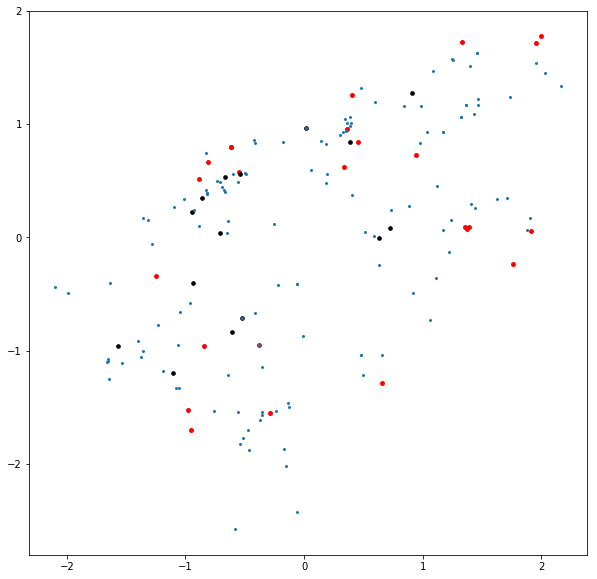

In [9]:
# Plot
plt.figure(figsize=(10,10))
plt.scatter(data_test[:,0], data_test[:,1], alpha=1, c='r', s=15)
plt.scatter(data_val[:,0], data_val[:,1], alpha=1, c='k', s=13)
plt.scatter(data_train[:,0], data_train[:,1], alpha=1, s=4)

In [10]:
########## DEFINITIONS!!!!!!!!!!!! https://github.com/ikostrikov/pytorch-flows/blob/master/flows.py
def get_mask(in_features, out_features, in_flow_features, mask_type=None):
    """
    mask_type: input | None | output
    
    See Figure 1 for a better illustration:
    https://arxiv.org/pdf/1502.03509.pdf
    """
    if mask_type == 'input':
        in_degrees = torch.arange(in_features) % in_flow_features
    else:
        in_degrees = torch.arange(in_features) % (in_flow_features - 1)

    if mask_type == 'output':
        out_degrees = torch.arange(out_features) % in_flow_features - 1
    else:
        out_degrees = torch.arange(out_features) % (in_flow_features - 1)

    return (out_degrees.unsqueeze(-1) >= in_degrees.unsqueeze(0)).float()


class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features, mask, cond_in_features=None, bias=True):
        super(MaskedLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        if cond_in_features is not None:
            self.cond_linear = nn.Linear(cond_in_features, out_features, bias=False)

        self.register_buffer('mask', mask)

    def forward(self, inputs, cond_inputs=None):
        masked_weights = self.linear.weight * self.mask
        output = F.linear(inputs, masked_weights, self.linear.bias)
        if cond_inputs is not None:
            output += self.cond_linear(cond_inputs)
        return output


nn.MaskedLinear = MaskedLinear


class MADE(nn.Module):
    """ An implementation of MADE
    (https://arxiv.org/abs/1502.03509s).
    """

    def __init__(self, num_inputs, num_hidden, num_cond_inputs=None, use_tanh=False):
        super(MADE, self).__init__()

        self.use_tanh = use_tanh

        input_mask = get_mask(
            num_inputs, num_hidden, num_inputs, mask_type='input')
        hidden_mask = get_mask(num_hidden, num_hidden, num_inputs)
        output_mask = get_mask(
            num_hidden, num_inputs * 2, num_inputs, mask_type='output')

        self.joiner = nn.MaskedLinear(num_inputs, num_hidden, input_mask, num_cond_inputs)

        self.trunk = nn.Sequential(
            nn.ReLU(),
            nn.MaskedLinear(num_hidden, num_hidden, hidden_mask),
            nn.ReLU(),
            nn.MaskedLinear(num_hidden, num_inputs * 2, output_mask))

    def forward(self, inputs, cond_inputs=None, mode='direct'):
        if mode == 'direct':
            h = self.joiner(inputs, cond_inputs)
            m, a = self.trunk(h).chunk(2, 1)
            if self.use_tanh:
                a = torch.tanh(a)
            u = (inputs - m) * torch.exp(-a)
            return u, -a.sum(-1, keepdim=True)

        else:
            x = torch.zeros_like(inputs)
            for i_col in range(inputs.shape[1]):
                h = self.joiner(x, cond_inputs)
                m, a = self.trunk(h).chunk(2, 1)
                if self.use_tanh:
                    a = torch.tanh(a)
                x[:, i_col] = inputs[:, i_col] * torch.exp(a[:, i_col]) + m[:, i_col]
        return x, -a.sum(-1, keepdim=True)

In [11]:
class Reverse(nn.Module):
    """ An implementation of a reversing layer from
    Density estimation using Real NVP
    (https://arxiv.org/abs/1605.08803).
    """

    def __init__(self, num_inputs):
        super(Reverse, self).__init__()
        self.perm = np.array(np.arange(0, num_inputs)[::-1])
        self.inv_perm = np.argsort(self.perm)

    def forward(self, inputs, cond_inputs=None, mode='direct'):
        if mode == 'direct':
            return inputs[:, self.perm], torch.zeros(
                inputs.size(0), 1, device=inputs.device)
        else:
            return inputs[:, self.inv_perm], torch.zeros(inputs.size(0), 1, device=inputs.device)

In [12]:
class BatchNormFlow(nn.Module):
    """ An implementation of a batch normalization layer from
    Density estimation using Real NVP
    (https://arxiv.org/abs/1605.08803).
    """

    def __init__(self, num_inputs, momentum=0.0, eps=1e-5):
        super(BatchNormFlow, self).__init__()

        self.log_gamma = nn.Parameter(torch.zeros(num_inputs))
        self.beta = nn.Parameter(torch.zeros(num_inputs))
        self.momentum = momentum
        self.eps = eps

        self.register_buffer('running_mean', torch.zeros(num_inputs))
        self.register_buffer('running_var', torch.ones(num_inputs))

    def forward(self, inputs, cond_inputs=None, mode='direct'):
        if mode == 'direct':
            if self.training:
                self.batch_mean = inputs.mean(0)
                self.batch_var = (
                    inputs - self.batch_mean).pow(2).mean(0) + self.eps

                self.running_mean.mul_(self.momentum)
                self.running_var.mul_(self.momentum)

                self.running_mean.add_(self.batch_mean.data *
                                       (1 - self.momentum))
                self.running_var.add_(self.batch_var.data *
                                      (1 - self.momentum))

                mean = self.batch_mean
                var = self.batch_var
            else:
                mean = self.running_mean
                var = self.running_var

            x_hat = (inputs - mean) / var.sqrt()
            y = torch.exp(self.log_gamma) * x_hat + self.beta
            return y, (self.log_gamma - 0.5 * torch.log(var)).sum(
                -1, keepdim=True)
        else:
            if self.training:
                mean = self.batch_mean
                var = self.batch_var
            else:
                mean = self.running_mean
                var = self.running_var

            x_hat = (inputs - self.beta) / torch.exp(self.log_gamma)

            y = x_hat * var.sqrt() + mean

            return y, (-self.log_gamma + 0.5 * torch.log(var)).sum(-1, keepdim=True)

In [13]:
class FlowSequential(nn.Sequential):
    """ A sequential container for flows.
    In addition to a forward pass it implements a backward pass and
    computes log jacobians.
    """

    def forward(self, inputs, cond_inputs=None, mode='direct', logdets=None):
        """ Performs a forward or backward pass for flow modules.
        Args:
            inputs: a tuple of inputs and logdets
            mode: to run direct computation or inverse
        """
        if logdets is None:
            logdets = torch.zeros(inputs.size(0), 1, device=inputs.device)

        assert mode in ['direct', 'inverse']
        if mode == 'direct':
            for module in self._modules.values():
                inputs, logdet = module(inputs, cond_inputs, mode)
                logdets += logdet
        else:
            for module in reversed(self._modules.values()):
                inputs, logdet = module(inputs, cond_inputs, mode)
                logdets += logdet

        return inputs, logdets

In [24]:
# Hyperparameters
# Architecture
num_inputs = data_train.shape[1]
num_blocks = 3
num_hidden = 32

# Training
epochs       = 3000
batch_size   = 132
lr           = 0.0001
log_interval = 100

In [25]:
# Training data
train_tensor = torch.from_numpy(data_train)
train_dataset = torch.utils.data.TensorDataset(train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Validation data
valid_tensor = torch.from_numpy(data_val)
valid_dataset = torch.utils.data.TensorDataset(valid_tensor)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# Test data
test_tensor = torch.from_numpy(data_test)
test_dataset = torch.utils.data.TensorDataset(test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [26]:
modules = []
for _ in range(num_blocks):
        modules += [
            MADE(num_inputs, num_hidden),
            BatchNormFlow(num_inputs),
            Reverse(num_inputs)
        ]

model = FlowSequential(*modules)

for module in model.modules():
    if isinstance(module, nn.Linear):
        nn.init.orthogonal_(module.weight)
        module.bias.data.fill_(0)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)
#model.to(device)

In [27]:
####### TRAINING!!!!!!!!!!!!!!!!!!!!!!!!!! https://github.com/ikostrikov/pytorch-flows/blob/master/main.py
def flow_loss(u, log_jacob, size_average=True):
    log_probs = (-0.5 * u.pow(2) - 0.5 * np.log(2 * np.pi)).sum(
        -1, keepdim=True)
    loss = -(log_probs + log_jacob).sum()
    if size_average:
        loss /= u.size(0)
    return loss


def train(epoch):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        if isinstance(data, list):
            data = data[0]
        #data = data.to(device)
        optimizer.zero_grad()
        u, log_jacob = model(data)
        loss = flow_loss(u, log_jacob)
        loss.backward()
        optimizer.step()
        if epoch % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    for module in model.modules():
        if isinstance(module, BatchNormFlow):
            module.momentum = 0

    with torch.no_grad():
        model(train_loader.dataset.tensors[0].to(data.device))

    for module in model.modules():
        if isinstance(module, BatchNormFlow):
            module.momentum = 1
            
    return loss


def validate(epoch, model, loader, prefix='Validation'):
    model.eval()
    val_loss = 0

    for data in loader:
        if isinstance(data, list):
            data = data[0]
        #data = data.to(device)
        with torch.no_grad():
            u, log_jacob = model(data)
            val_loss += flow_loss(u, log_jacob, size_average=False).item()  # sum up batch loss

    val_loss /= len(loader.dataset)
    if epoch % log_interval == 0:
        print('\n{} set: Average loss: {:.4f}\n'.format(prefix, val_loss))

    return val_loss

In [28]:
best_validation_loss = float('inf')
best_validation_epoch = 0
best_model = model

train_loss = []
val_loss = []
for epoch in range(epochs):

    train_loss.append(train(epoch))
    validation_loss = validate(epoch, model, valid_loader)
    val_loss.append(validation_loss)
    
    # Learning rate schedule
    if epoch==1000:
        optimizer = optim.Adam(model.parameters(), lr=lr/5, weight_decay=1e-6)

    #if epoch - best_validation_epoch >= 30:
    #    break

    if validation_loss < best_validation_loss:
        best_validation_epoch = epoch
        best_validation_loss = validation_loss
        #best_model = copy.deepcopy(model)

print('Best validation at epoch {}: Average loss: {:.4f}\n'.format(best_validation_epoch, best_validation_loss))

Train Epoch: 0 [0/132 (0%)]	Loss: 2.923801

Validation set: Average loss: 2.4616

Train Epoch: 100 [0/132 (0%)]	Loss: 2.697189

Validation set: Average loss: 2.3108

Train Epoch: 200 [0/132 (0%)]	Loss: 2.616520

Validation set: Average loss: 2.2901

Train Epoch: 300 [0/132 (0%)]	Loss: 2.582594

Validation set: Average loss: 2.2801

Train Epoch: 400 [0/132 (0%)]	Loss: 2.526816

Validation set: Average loss: 2.2278

Train Epoch: 500 [0/132 (0%)]	Loss: 2.394381

Validation set: Average loss: 2.1021

Train Epoch: 600 [0/132 (0%)]	Loss: 2.340443

Validation set: Average loss: 2.0937

Train Epoch: 700 [0/132 (0%)]	Loss: 2.302674

Validation set: Average loss: 2.0929

Train Epoch: 800 [0/132 (0%)]	Loss: 2.280540

Validation set: Average loss: 2.0972

Train Epoch: 900 [0/132 (0%)]	Loss: 2.261181

Validation set: Average loss: 2.0995

Train Epoch: 1000 [0/132 (0%)]	Loss: 2.237773

Validation set: Average loss: 2.1068

Train Epoch: 1100 [0/132 (0%)]	Loss: 2.233154

Validation set: Average loss: 

In [29]:
validate(best_validation_epoch, model, test_loader, prefix='Test')

1027.93421875

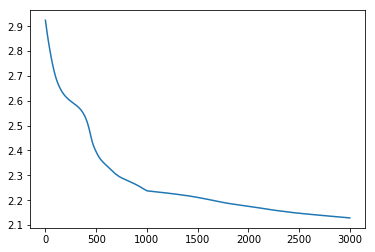

In [30]:
plt.plot(range(len(train_loss)), train_loss)

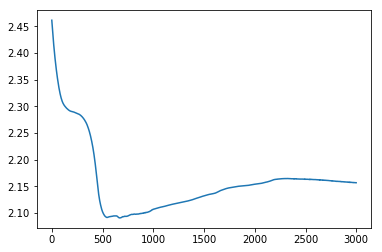

In [31]:
plt.plot(range(len(val_loss)), val_loss)

In [ ]:
# SMALL DATASET
# blocks:2, hidden:32, lr:1e-4, batch: 20
# Best validation at epoch 1051: Average loss: 2.3087
# Test val: 2.933855667114258

##### 3 blocks
# blocks:3, hidden:16, lr:1e-4, batch: 20
# Best validation at epoch 161: Average loss: 2.6720
# Test val: 3.0800845336914064

*****************************************************
# blocks:3, hidden:32, lr:1e-4, batch: 100
# Best validation at epoch 980: Average loss: 2.3463
# 2.534503664289202
*****************************************************

# blocks:3, hidden:64, lr:1e-4, batch: 20
# Best validation at epoch 127: Average loss: 2.6778
# Test val: 3.09565185546875

##### 4 blocks
# blocks:4, hidden:32, lr:1e-4, batch: 20
# Best validation at epoch 128: Average loss: 2.7206
# Test val: 2.9415998458862305

##### 5 blocks
# blocks:5, hidden:32, lr:1e-4, batch: 20
# Best validation at epoch 1087: Average loss: 2.2731
# Test val: 3.6483302307128906

In [ ]:
# MASSIVE DATASET
# blocks:2, hidden:32, lr:1e-4, batch: 20
# Best validation at epoch 1051: Average loss: 2.3087
# Test val: 2.933855667114258

##### 3 blocks
# blocks:3, hidden:16, lr:1e-4, batch: 20
# Best validation at epoch 161: Average loss: 2.6720
# Test val: 3.0800845336914064

*****************************************************
# blocks:3, hidden:32, lr:1e-4, batch: 20
# Best validation at epoch 2882: Average loss: 2.1636
# Test val: 2.8273855590820314
*****************************************************

# blocks:3, hidden:64, lr:1e-4, batch: 20
# Best validation at epoch 1986: Average loss: 2.3757
# Test val: 2.53014646257673

##### 4 blocks
# blocks:4, hidden:32, lr:1e-4, batch: 20
# Best validation at epoch 128: Average loss: 2.7206
# Test val: 2.9415998458862305

##### 5 blocks
# blocks:5, hidden:32, lr:1e-4, batch: 100
# Best validation at epoch 913: Average loss: 2.2788
# Test val: 2.3675338200160434

##### 7 blocks
# blocks:5, hidden:32, lr:1e-4, batch: 100
# Best validation at epoch 965: Average loss: 2.3375
# Test val: 2.490167890276228

##### 10 blocks
# blocks:5, hidden:32, lr:1e-4, batch: 100
# Validation set: Average loss: 2.2701
# Test val: 2.4523631504603793

In [22]:
def plot_density(model):#, directory):

    size = 100
    X_LIMS = (-3, 3)
    Y_LIMS = (-2.5, 2.5)

    x1 = np.linspace(*X_LIMS, size)
    x2 = np.linspace(*Y_LIMS, size)
    x1, x2 = np.meshgrid(x1, x2)
    shape = x1.shape
    x1 = x1.ravel()
    x2 = x2.ravel()

    z_np = np.c_[x1, x2]
    z = torch.FloatTensor(z_np)
    z = torch.autograd.Variable(z)

    u, _ = model(z)
    log_probs = (-0.5 * u.pow(2) - 0.5 * np.log(2 * np.pi)).sum(-1, keepdim=True)
    log_probs = log_probs.detach().numpy()#.reshape(shape)

    z_np = np.c_[z_np, np.exp(log_probs)]

    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    ax.set_aspect('equal')
    #ax.imshow(log_probs, extent=(*X_LIMS, *Y_LIMS), cmap="summer")
    ax.tricontourf(z_np[:,0], z_np[:,1], z_np[:,2], cmap=plt.get_cmap('binary'))
    ax.scatter(data_train[:,0], data_train[:,1], alpha=1, c='w', s=1)
    ax.scatter(data_test[:,0], data_test[:,1], alpha=1, c='r', s=15)
    ax.set_title("True density")

    #fig.savefig(os.path.join(directory, "density.png"))
    plt.show()
    
    return log_probs

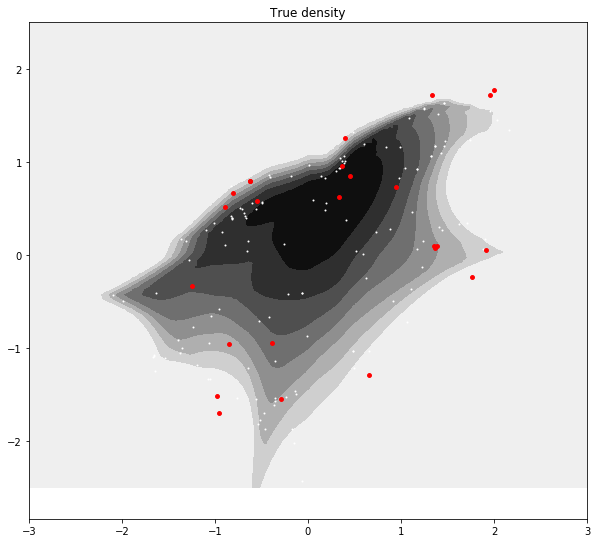

In [32]:
density_vals = plot_density(model=model)

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

distribution = ax.tricontourf(resultadosFinales[:,1], resultadosFinales[:,0], resultadosFinales[:,2], cmap=plt.get_cmap('binary'))
#bogota_pequeña.plot(ax=ax, color='none', edgecolor='black')
plt.scatter(labeledDatosUnaHora.Longitud, labeledDatosUnaHora.Latitud, alpha=1, s=0.5, color='red') # Prediction points

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.xlim(-74.22, -74.009)
plt.ylim(4.47, 4.835)

fig.tight_layout()

In [ ]:
Coordenadas = pd.read_pickle("C://Users//USUARIO//Desktop//Sergio//Investigacion//Tesis//Programacion//coords0.p")
Coordenadas = Coordenadas.drop([item for item in list(Coordenadas) if item not in ['lat', 'lon']], axis = 1)
Coordenadas.columns = ["Latitud", "Longitud"]

In [ ]:
# Define the parametrized relu subclass: https://blog.evjang.com/2018/01/nf1.html
class PRelu(Transform):
    def __init__(self, nvars, alpha=0.5, prior = None, name = "PRelu"):
        super(PRelu, self).__init__(nvars, prior, name)

        self.alpha = alpha

    def inverse(self,y):
        inverse_Jac = torch.ones(y.shape[0])
        inverse_Jac = torch.where(torch.ge(y, 0), (1/torch.abs(self.scale)), (1 /(self.alpha*torch.abs(self.scale)))) 
        inverse_Log_Jac = torch.log(inverse_Jac+eps)
        y = torch.where(torch.ge(y, 0), y, (1 / self.alpha)*y)
        return y, inverse_Log_Jac

    def forward(self,z):
        z = self.scale*z + self.bias
        forward_Jac = torch.ones(z.shape[0])
        forward_Jac = torch.where(torch.ge(z, 0), torch.abs(self.scale), torch.tensor(self.alpha))
        forward_Log_Jac = torch.log(forward_Jac+eps)
        z = torch.where(torch.ge(z, 0), z, self.alpha*z) # Forward pass
        return z, forward_Log_Jac

In [ ]:
##### Alternative dataset loading

In [ ]:
train_set = train_set.set_index('complete_date')
train_set.longitud.resample('M').mean()

In [ ]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

# Get unique names of species
uniq = list(set(train_set['month']))

# Set the color map to match the number of species
z = range(1,len(uniq))
hot = plt.get_cmap('hot')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

# Plot each month
for i in range(len(uniq)):
    indx = train_set['month'] == uniq[i]
    plt.figure()
    plt.scatter(train_set.latitud[indx], train_set.longitud[indx], s=15, color=scalarMap.to_rgba(i), label=uniq[i])
    plt.legend(loc='best')
    plt.xlim(4.48, 4.81)
    plt.ylim(-74.2, -74.01)
    plt.show()

train_set.plot.scatter(x='latitud', y='longitud', c='month')

In [ ]:
# Basic data loading, if npy file exists, use it, otherwise load the txt and create the npy
if os.path.isfile('./data/CrimenBogota.npy'):
    crimen = np.load('./data/CrimenBogota.npy')
else: 
    crimen = pd.read_csv('./data/CrimenBogota.txt', sep=' ')
    crimen = np.asarray(crimen)
    np.save('./data/CrimenBogota.npy', crimen)
# ['Latitud', 'Longitud', 'Hora', 'Minuto', 'Segundo', 'Dia', 'Mes', 'Año', 'DiaSemana', 'Tipo'] these are the column names 